# NFL Elimination Picks

In [24]:
import bisect
import collections
import datetime
import enum
import errno
import heapq
import json
import math
import random
import statistics
import typing

import matplotlib.pyplot as plt
import numpy as np
import parsel
import pandas as pd
import requests

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import anysunday
import anysunday.powercalcs
from anysunday import viz

In [4]:
schedule = anysunday.loaders.espn_schedule("./schedules/2021.espn")

https://www.espn.com/nfl/fpi

In [25]:
powers = anysunday.loaders.espn_powers()
powers

{'BUF': 9.6,
 'TB': 6.8,
 'LAR': 4.5,
 'KC': 4.4,
 'ARI': 4.3,
 'DAL': 4.2,
 'BAL': 3.3,
 'NO': 2.9,
 'CLE': 2.8,
 'LAC': 2.7,
 'GB': 2.1,
 'SF': 2.0,
 'DEN': 1.0,
 'MIN': 0.9,
 'CAR': 0.6,
 'SEA': 0.2,
 'NE': -0.2,
 'TEN': -0.4,
 'PIT': -0.6,
 'IND': -0.8,
 'CIN': -1.8,
 'LV': -1.8,
 'PHI': -2.1,
 'CHI': -2.4,
 'WSH': -2.6,
 'NYG': -3.3,
 'MIA': -3.7,
 'ATL': -3.9,
 'DET': -5.5,
 'HOU': -7.6,
 'JAX': -7.8,
 'NYJ': -7.8}

In [6]:
top_picks = list(powers)[:17]
best_pick = None
best_pick_fitness = -100

def fitness(scores):
    return 100 * min(scores) + sum(scores)

def fitness(scores):
    return 50 * (min(scores) - 3) + sum(scores)

picks = []

HOME_POWER_BUMP = 3.0

for n in range(100_000):
    this_pick = top_picks[:]
    random.shuffle(this_pick)
    try:
        scores = anysunday.powercalcs.pick_power_calculator(powers, schedule, this_pick)
    except ValueError:
        continue
    
    pick_fitness = fitness(scores)
    
    if pick_fitness < 0:
        continue

    picks.append([min(scores), sum(scores)])
    
    if pick_fitness < best_pick_fitness:
        continue
    
    print("new high score, round {:>9d}, fitness={:+3.1f}".format(n, pick_fitness))
    best_pick = this_pick
    best_scores = scores
    best_pick_fitness = pick_fitness


new high score, round      4954, fitness=+54.1
new high score, round     40523, fitness=+64.0
new high score, round     62777, fitness=+64.0
new high score, round     86182, fitness=+74.4


In [7]:
anysunday.powercalcs.pick_power_calculator(powers, schedule, best_pick, verbose=True)

week  1: diff +12.4 - picking BUF (+8.3+H) over PIT (-1.1  )
week  2: diff +14.3 - picking CLE (+3.1+H) over HOU (-8.2  )
week  3: diff +11.7 - picking DEN (+1.4+H) over NYJ (-7.3  )
week  4: diff  +3.3 - picking LAR (+4.3+H) over ARI (+4.0  )
week  5: diff +10.1 - picking MIN (+1.3+H) over DET (-5.8  )
week  6: diff  +4.9 - picking TB  (+5.4  ) over PHI (-2.5+H)
week  7: diff +10.7 - picking NE  (+0.4+H) over NYJ (-7.3  )
week  8: diff  +2.9 - picking SF  (+2.2  ) over CHI (-3.7+H)
week  9: diff +10.2 - picking NO  (+2.5+H) over ATL (-4.7  )
week 10: diff  +4.0 - picking KC  (+5.9  ) over LV  (-1.1+H)
week 11: diff  +5.7 - picking CAR (+1.0+H) over WSH (-1.7  )
week 12: diff  +3.5 - picking BAL (+3.6+H) over CLE (+3.1  )
week 13: diff  +2.1 - picking SEA (+1.3+H) over SF  (+2.2  )
week 14: diff  +8.6 - picking GB  (+1.9+H) over CHI (-3.7  )
week 15: diff  +3.2 - picking DAL (+3.4  ) over NYG (-2.8+H)
week 16: diff  +7.9 - picking ARI (+4.0+H) over IND (-0.9  )
week 17: diff  +3.9 - pi

[12.4,
 14.299999999999999,
 11.7,
 3.3,
 10.1,
 4.9,
 10.7,
 2.9000000000000004,
 10.2,
 4.0,
 5.7,
 3.5,
 2.0999999999999996,
 8.6,
 3.1999999999999993,
 7.9,
 3.9]

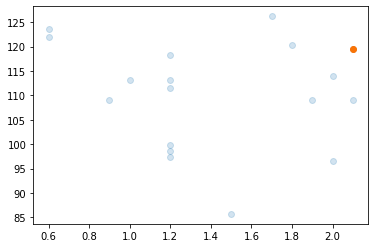

In [8]:
best_scores = anysunday.powercalcs.pick_power_calculator(powers, schedule, best_pick)
best_point = [min(best_scores), sum(best_scores)]

f, ax = plt.subplots()
ax.scatter(*zip(*picks), alpha=0.2)

ax.scatter(*best_point, color="xkcd:orange")

(<Figure size 576x720 with 2 Axes>,
 <AxesSubplot:xlabel='Week', ylabel='Pick to Win'>)

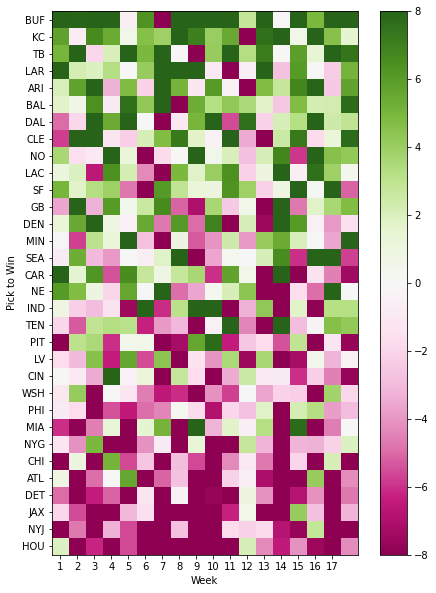

In [9]:
power_rank, matrix = anysunday.powercalcs.pick_grid(powers, schedule, home_bump=3)

viz.plot_matrix(matrix, power_rank)

In [10]:
class PickModes(enum.Enum):
    BEST = "best"
    RANDOM = "random"
    RANDOM_BIASED = "random_biased"

NUM_WEEKS = 18

class PickPermuter:
    def __init__(self, powers, schedule, home_bump=HOME_POWER_BUMP, past_picks=None):
        self.powers = powers
        
        self.schedule = schedule
        self.home_bump = home_bump
        
        self.update_pick_grid()
        
        if past_picks is None:
            self.past_picks = []
        else:
            self.past_picks = list(past_picks)
        
        self.pick = self.greedy()
                
    def update_pick_grid(self):
        self.grid_index, self.grid = anysunday.powercalcs.pick_grid(self.powers, self.schedule, self.home_bump)

    def __repr__(self):
        score = self.pick_score
#         return "<{}\n {}\n {}\n min={}, avg={}, max={}>".format(
        return "<{}\n {}\n min={}, avg={}, max={}>".format(
            self.__class__.__name__,
            ", ".join(f"{p:>2s}" for p in self.pick),
#             ", ".join(f"{p:>5s}" for p in self.pick),
#             ", ".join(f"{s:>+4.1f}" for s in score),
            min(self.pick_score),
            statistics.mean(self.pick_score),
            max(self.pick_score),
        )

    def _make_pick(self, week, exclusions=None, mode=PickModes.BEST):
        if exclusions is None:
            exclusions = set()
            
        if mode is PickModes.BEST:
            picks = sorted(list(zip(week, self.grid_index)), reverse=True)
        elif mode is PickModes.RANDOM:
            picks = list(zip(week, self.grid_index))
            random.shuffle(picks)
        elif mode is PickModes.RANDOM_BIASED:
            picks = list(zip(week, self.grid_index))
            random.shuffle(picks)
        else:
            raise ValueError("unknown pick mode")
        for _score, pick in picks:
            if pick in exclusions:
                continue
            return pick    
        raise RuntimeError("no valid pick")
    
    def random(self):
        picks = self.past_picks[:] + [None] * (NUM_WEEKS - len(self.past_picks))
        n_weeks = list(range(len(self.past_picks), NUM_WEEKS))
        random.shuffle(n_weeks)
        for n_week in n_weeks:
            week = self.grid[n_week]
            pick = self._make_pick(week, exclusions=picks, mode=PickModes.RANDOM)
            picks[n_week] = pick
        return picks

    def greedy(self):
        picks = self.past_picks[:]
        for week in self.grid[len(picks):]:
            pick = self._make_pick(week, exclusions=picks)
            picks.append(pick)
        assert len(picks) == len(self.grid) == NUM_WEEKS
        return picks
    
    def reverse_greedy(self):
        picks = []
        for week in reversed(self.grid[len(self.past_picks):]):
            pick = self._make_pick(week, exclusions=picks + self.past_picks)
            picks.append(pick)
        picks = self.past_picks + picks[::-1]
        assert len(picks) == len(self.grid) == NUM_WEEKS
        return picks
    
    def random_greedy(self):
        picks = self.past_picks[:] + [None] * (NUM_WEEKS - len(self.past_picks))
        n_weeks = list(range(len(self.past_picks), NUM_WEEKS))
        random.shuffle(n_weeks)
        for n_week in n_weeks:
            week = self.grid[n_week]
            pick = self._make_pick(week, exclusions=picks)
            picks[n_week] = pick
        return picks

    def limited_greedy(self, limit=10):
        picks = self.past_picks[:]
        for week in self.grid[len(picks):]:
            worst_picks = sorted(list(zip(week, self.grid_index)))
            pivot_index = bisect.bisect_left(worst_picks, (limit, "X"))
            order = (worst_picks[pivot_index:] + list(reversed(worst_picks[:pivot_index])))
            for _score, pick in order:
                if pick not in picks:
                    picks.append(pick)
                    break
            else:
                raise RuntimeError()
        assert len(picks) == len(self.grid) == NUM_WEEKS
        return picks
    
#     def greedy_anneal(self):
#         picks = self.greedy()
    
    @property
    def pick_score(self):
        return anysunday.powercalcs.pick_power_calculator(self.powers, self.schedule, self.pick, home_power=self.home_bump)
    
    def describe_pick(self):
        anysunday.powercalcs.pick_power_calculator(
            self.powers, self.schedule, self.pick, 
            home_power=self.home_bump, 
            verbose=True, 
            ignore_weeks=len(self.past_picks),
        )
        
    @property
    def fitness(self):
#         return sum(score * k for score, k in zip(heapq.nsmallest(3, self.pick_score), [10, 3, 1]))
        return sum(score * 2**n for n, score in enumerate(sorted(self.pick_score, reverse=True)))

In [26]:
my_past_picks = [
    "LAR", # week 1
    "NYJ", # week 2 (not a real pick...didn't really pick :/)
    "DEN", # week 3
    "BUF", # week 4
    "MIN", # week 5
]

tuned_home_bump = 1.5

ppkwargs = {
    "powers": powers,
    "schedule": schedule,
    "home_bump": tuned_home_bump,
    "past_picks": my_past_picks
}

In [12]:
pp = PickPermuter(**ppkwargs)

pprev = PickPermuter(**ppkwargs)
pprev.pick = pprev.reverse_greedy()

pprand = PickPermuter(**ppkwargs)
pprand.pick = pprand.random_greedy()

pplg = PickPermuter(**ppkwargs)
pplg.pick = pplg.limited_greedy(limit=8)

In [13]:
pp.describe_pick()

ValueError: 17 weeks of picks needed

In [ ]:
pprev.describe_pick()

In [ ]:
pprand.describe_pick()

In [ ]:
pplg.describe_pick()

In [ ]:
best_picks = []
best_fitness = -100
for n in range(100_000):
    pprand.pick = pprand.random_greedy()
    
    if pprand.fitness > best_fitness:
        print("new best fitness", int(pprand.fitness))
        best_picks = pprand.pick
        best_fitness = pprand.fitness
        
pprand.pick = best_picks
pprand.describe_pick()

In [ ]:
best_picks = []
best_fitness = -100
for n in range(2_000_000):
    pprand.pick = pprand.random()
    
    try:
        if pprand.fitness > best_fitness:
            print("new best fitness", int(pprand.fitness))
            best_picks = pprand.pick
            best_fitness = pprand.fitness
    except ValueError:
        continue
        
pprand.pick = best_picks
pprand.describe_pick()

## FiveThirtyEight Elo Data

* Links
    * https://projects.fivethirtyeight.com/2020-nfl-predictions/
    * https://github.com/fivethirtyeight/data/tree/master/nfl-elo
* Important Fields
    * `team1`	Abbreviation for home team
    * `team2`	Abbreviation for away team
    * `qbelo_prob1`	Home team's probability of winning according to quarterback-adjusted Elo
    * `qbelo_prob2`	Away team's probability of winning according to quarterback-adjusted Elo

In [27]:
data = anysunday.loaders.five38_elos()

In [28]:
data.shape

(272, 33)

In [29]:
data

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating
0,2021-09-09,2021,0,NaN,TB,DAL,1656.235930,1452.424236,0.824539,0.175461,...,397.401725,223.782352,248.082791,1639.815956,1500.264612,31.0,29.0,85,48,67
1,2021-09-12,2021,0,NaN,CAR,NYJ,1436.539318,1381.747500,0.665873,0.334127,...,-8.498819,116.688831,100.353462,1470.504096,1380.536121,19.0,14.0,12,36,24
2,2021-09-12,2021,0,NaN,TEN,ARI,1553.397217,1486.436956,0.681272,0.318728,...,302.017311,190.370826,225.696909,1489.651053,1528.361042,13.0,38.0,56,59,58
3,2021-09-12,2021,0,NaN,HOU,JAX,1432.775542,1339.023563,0.713787,0.286213,...,82.479069,137.164623,109.859329,1391.718434,1350.757949,37.0,21.0,0,17,9
4,2021-09-12,2021,0,NaN,DET,SF,1390.645249,1490.665951,0.449771,0.550229,...,175.216924,171.513676,132.495404,1355.200609,1562.414869,33.0,41.0,23,45,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2022-01-09,2021,0,NaN,PHI,DAL,1423.894031,1527.926062,0.444064,0.555936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54,68,61
268,2022-01-09,2021,0,NaN,OAK,LAC,1483.966869,1566.315003,0.475055,0.524945,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64,73,69
269,2022-01-09,2021,0,NaN,DEN,KC,1466.205951,1594.416838,0.410023,0.589977,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,97,85
270,2022-01-09,2021,0,NaN,ARI,SEA,1605.032103,1542.655720,0.675515,0.324485,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81,80,81


In [30]:
import dateutil.parser

NUM_TEAMS = 32

WEEK_1_WED = datetime.datetime(year=2021, month=9, day=9)
TEAM_RENAMES = {
    "OAK": "LV",  # Raiders
}

def date_to_week(date):
    if not isinstance(date, datetime.datetime):
        date = dateutil.parser.parse(date)
    day_diff = (date - WEEK_1_WED) / datetime.timedelta(days=1)
    return int((day_diff // 7) + 1)

def pick_grid_538(data):
    powers = {}
    matches = []
    for _index, row in data.iterrows():
        week = date_to_week(row["date"])
        if week > NUM_WEEKS: 
            break
        for n in "12":
            team = row[f"team{n}"]
            elo = row[f"qbelo{n}_post"]
            p_win = row[f"qbelo_prob{n}"]
            if not math.isnan(elo):
                powers[team] = elo
            matches.append((team, week, p_win))

    index = sorted(powers, key=lambda t: powers[t])
    matrix = [[-10] * NUM_TEAMS for _ in range(NUM_WEEKS)]
    for team, week, p_win in matches:
        matrix[week - 1][index.index(team)] = 20 * (p_win - 0.5)
    
    # 538 uses old names as they have historical(ish) data
    index = [TEAM_RENAMES.get(n, n) for n in index]
    return index, matrix

(<Figure size 576x720 with 2 Axes>,
 <AxesSubplot:xlabel='Week', ylabel='Pick to Win'>)

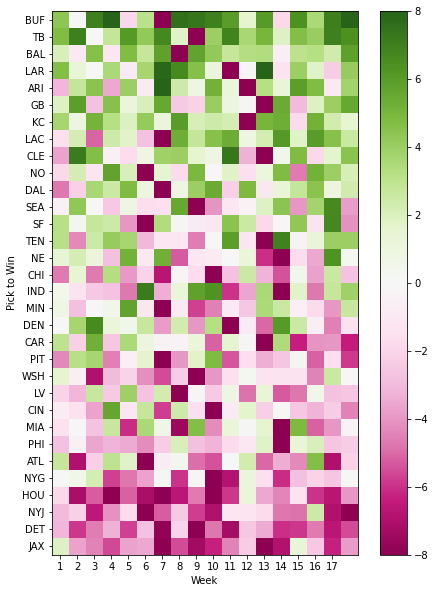

In [31]:
index538, matrix538 = pick_grid_538(data)
viz.plot_matrix(matrix538, index538)

In [32]:
class ProbPickPermuter(PickPermuter):
    def __init__(self, df, past_picks=None):
        self.past_picks = past_picks or []
        
        self.df = df.copy()
        self.df["week"] = self.df["date"].apply(date_to_week)
        
        # ignore postseason games
        self.df = self.df[self.df["week"] <= NUM_WEEKS]
    
        self.grid_index, self.grid = pick_grid_538(self.df)
        
        self.pick = self.greedy()

    @property
    def pick_score(self):
        scores = []
        for week in range(NUM_WEEKS):
            pick = self.pick[week]
            pick_index = self.grid_index.index(pick)
            scores.append(self.grid[week][pick_index])
        return scores

In [33]:
ppp = ProbPickPermuter(data, past_picks=my_past_picks)
ppp.pick = ppp.greedy()
ppp.fitness

135648.35280676704

In [ ]:
ppp = ProbPickPermuter(data, past_picks=my_past_picks)

best_538_picks = []
best_538_fitness = -100
for n in range(10_000_000):
    ppp.pick = ppp.random_greedy()
    
    if ppp.fitness > best_538_fitness:
        print("new best fitness", int(ppp.fitness))
        best_538_picks = ppp.pick
        print(" ".join(format(p, ">3s") for p in best_538_picks))
        best_538_fitness = ppp.fitness
        
ppp.pick = best_538_picks
ppp.pick 

new best fitness 206820
LAR NYJ DEN BUF MIN CIN ARI  KC  NO IND CLE DAL  TB TEN MIA LAC  SF BAL
new best fitness 339222
LAR NYJ DEN BUF MIN IND ARI  KC  NO PIT CLE DAL  TB TEN MIA LAC  SF BAL
new best fitness 342196
LAR NYJ DEN BUF MIN IND  NE SEA BAL PIT CLE DAL  KC TEN ARI LAC  TB  GB
new best fitness 343771
LAR NYJ DEN BUF MIN IND  GB SEA BAL PIT CLE DAL  KC TEN ARI LAC  SF  TB
new best fitness 343833
LAR NYJ DEN BUF MIN IND  TB SEA BAL PIT CLE DAL  KC TEN ARI LAC  SF  GB
new best fitness 344357
LAR NYJ DEN BUF MIN IND  NE  KC BAL ARI CLE DAL  TB TEN MIA LAC  SF  GB
new best fitness 344584
LAR NYJ DEN BUF MIN IND  GB SEA BAL ARI CLE DAL  KC TEN MIA LAC  SF  TB
new best fitness 344623
LAR NYJ DEN BUF MIN IND  TB SEA BAL ARI CLE DAL  KC TEN MIA LAC  SF  GB


In [ ]:
print(" ".join(format(p, ">3s") for p in pprand.pick))
print(" ".join(format(p, ">3s") for p in best_538_picks))